<a href="https://colab.research.google.com/github/poliduckie/MPC/blob/main/U_net_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [205]:
from google.colab import drive
drive.mount('/content/drive')

TRAIN_PATH = '/content/drive/My Drive/SEGMENTATION/UNET1/train'
TEST_PATH = '/content/drive/My Drive/SEGMENTATION/UNET1/test/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 as cv2
import sys

In [207]:
import os
from google.colab.patches import cv2_imshow

length = len([entry for entry in os.listdir(TRAIN_PATH+'/img') if os.path.isfile(os.path.join(TRAIN_PATH+'/img', entry))])
print('the number of train images is: ', length)

the number of train images is:  21


# DATASET PREPARATION

In [208]:
train_ids = next(os.walk(TRAIN_PATH+'/img'))[2]
train_mask = next(os.walk(TRAIN_PATH+'/masks'))[2]
test_ids= next(os.walk(TEST_PATH))[2]
print(train_ids)
length = len(train_ids)
length_test = len(test_ids)
print(length)

print(test_ids)

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png']
21
['21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png']


In [209]:
X_train = np.zeros((length, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_test = np.zeros((length, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((length, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


## RESIZING IMAGES (TO MODIFY WITH AUTOENCODER)

In [210]:
print('Resizing and filtering training masks')
for n, id_ in tqdm(enumerate(train_mask), total=length):
  mask_path = TRAIN_PATH+'/masks/' +id_
  img = imread(mask_path)
  # Make all perfectly magenta pixels black (ducks)
  img[np.all(img == (255, 0, 254), axis=-1)] = (0,0,0)
  # Make all perfectly yellow pixels white (middle line)
  img[np.all(img == (255, 255, 0), axis=-1)] = (255,255,255)

  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range='true' )

  img=img[:,:,:1]

 
  Y_train[n] = img


Resizing and filtering training masks


100%|██████████| 21/21 [00:00<00:00, 31.65it/s]


In [211]:
print('Resizing training images')
for n, id_ in tqdm(enumerate(train_ids), total=length):
  path = TRAIN_PATH+'/img/'+ id_
  img= imread(path)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range='true' )
  X_train[n] = img

Resizing training images


100%|██████████| 21/21 [00:00<00:00, 54.34it/s]


In [212]:
print('Resizing training images')
for n, id_ in tqdm(enumerate(test_ids), total=length_test):
  path = TEST_PATH+ id_
  img= imread(path)[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range='true' )
  X_test[n] = img

Resizing training images


100%|██████████| 10/10 [00:00<00:00, 58.06it/s]


## show training images and mask

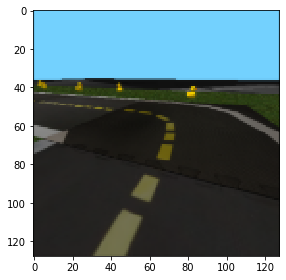

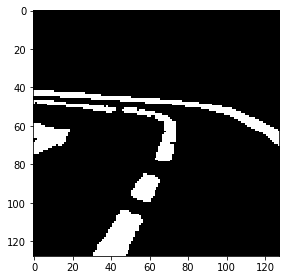

In [213]:
np.set_printoptions(threshold=sys.maxsize)

imageno = 3

 
imshow(X_train[imageno])
plt.show()

im=np.squeeze(Y_train[imageno])
indices = im.astype(np.uint8)  #convert to an unsigned byte
indices*=255
imshow(indices)
plt.show()

# MODEL



In [214]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

conversion of the imputs values (0-255) to float

In [215]:
s = tf.keras.layers.Lambda(lambda x:x /255)(inputs)

## ENCODING PART


2 conv layers.

Initializer defines the starting values for the wights, with  truncated gaussian distribuiton (starting from 0)

with padding we want the output = to input size

we do a dropout ot generalize the network between the two convolutions

In [216]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

In [217]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

In [218]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

In [219]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

## BOTTOM

In [220]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c5)

## DECODING PATH

In [221]:
u6 = tf.keras.layers.Convolution2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4]) #mergre with old layer
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c6)

In [222]:
u7 = tf.keras.layers.Convolution2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])  #mergre with old layer
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c7)

In [223]:
u8 = tf.keras.layers.Convolution2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])  #mergre with old layer
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c8)

In [224]:
u9 = tf.keras.layers.Convolution2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])  #mergre with old layer
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer='he_normal', padding='same')(c9)

In [225]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)

## checking that the model is correct

In [226]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

adam is a backpropagation optimizer (the traditional is stocastic gradient descent)

the optimizer is trying to minimize the loss function


## model ckeckpoint

In [227]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('duckie_street.h5', verbose=1, save_best_only=True)

In [248]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]


In [250]:
results = model.fit(X_train,Y_train, validation_split=0.1, batch_size=2, epochs=100, callbacks=callbacks)

Epoch 1/100
9/9 [==============================] - 5s 497ms/step - loss: 0.0488 - val_loss: 0.0536
Epoch 2/100
9/9 [==============================] - 4s 496ms/step - loss: 0.0490 - val_loss: 0.0330
Epoch 3/100
9/9 [==============================] - 5s 512ms/step - loss: 0.0561 - val_loss: 0.0511
Epoch 4/100
9/9 [==============================] - 4s 493ms/step - loss: 0.0805 - val_loss: 0.0538
Epoch 5/100
9/9 [==============================] - 4s 479ms/step - loss: 0.0652 - val_loss: 0.0461
Epoch 6/100
9/9 [==============================] - 4s 492ms/step - loss: 0.0568 - val_loss: 0.0393
Epoch 7/100
9/9 [==============================] - 4s 503ms/step - loss: 0.0496 - val_loss: 0.0319
Epoch 8/100
9/9 [==============================] - 4s 494ms/step - loss: 0.0492 - val_loss: 0.0294
Epoch 9/100
9/9 [==============================] - 4s 490ms/step - loss: 0.0445 - val_loss: 0.0330
Epoch 10/100
9/9 [==============================] - 5s 510ms/step - loss: 0.0396 - val_loss: 0.0302
Epoch 11/

# TRAINING

In [251]:
import random

seed = 42
np.random.seed = seed

1/1 [==============================] - 1s 868ms/step


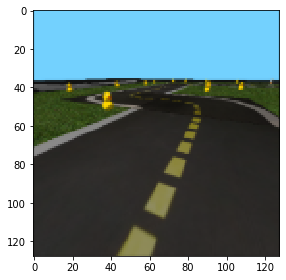

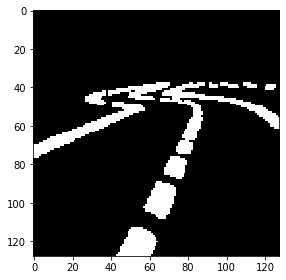

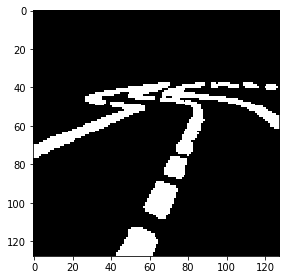

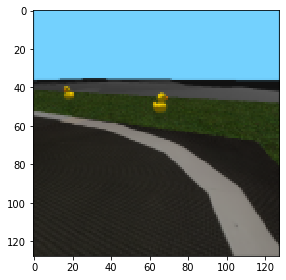

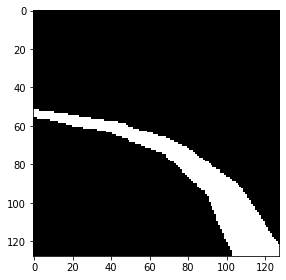

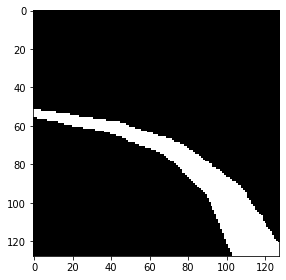

In [257]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


#Snity check on random training samples


ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()

im=np.squeeze(Y_train[ix])
indices = im.astype(np.uint8)  #convert to an unsigned byte
indices*=255
imshow(indices)

plt.show()

im3 = np.squeeze(preds_train_t[ix])
im3*=255
imshow(im3) 
plt.show()



#sanity on validation ex

ix =random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()

im2 = np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
indices = im2.astype(np.uint8)
indices*=255
imshow(indices) 
plt.show()


im3 = np.squeeze(preds_val_t[ix])
im3*=255
imshow(im3) 
plt.show()